## 4.10 Homework

Use [this notebook](homework-4-starter.ipynb) as a starter

We'll use the credit scoring dataset:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv')
df.columns = df.columns.str.lower()

In [3]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [4]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

In [5]:
df = df[df.status != 'unk'].reset_index(drop=True)

In [6]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

In [7]:
df.head().T

,0,1,2,3,4
seniority,9,17,10,0,0
home,rent,rent,owner,rent,rent
time,60,60,36,60,36
age,30,58,46,24,26
marital,married,widow,married,single,single
records,no,no,yes,no,no
job,freelance,fixed,freelance,fixed,fixed
expenses,73,48,90,63,46
income,129,131,200,182,107
assets,0,0,3000,2500,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4454 entries, 0 to 4453
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   seniority  4454 non-null   int64 
 1   home       4454 non-null   object
 2   time       4454 non-null   int64 
 3   age        4454 non-null   int64 
 4   marital    4454 non-null   object
 5   records    4454 non-null   object
 6   job        4454 non-null   object
 7   expenses   4454 non-null   int64 
 8   income     4454 non-null   int64 
 9   assets     4454 non-null   int64 
 10  debt       4454 non-null   int64 
 11  amount     4454 non-null   int64 
 12  price      4454 non-null   int64 
 13  default    4454 non-null   int32 
dtypes: int32(1), int64(9), object(4)
memory usage: 469.9+ KB


## Preparation 

* Execute the preparation code from the starter notebook
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

del df_train['default']
del df_val['default']
del df_test['default']

In [13]:
df_train.shape, df_val.shape, df_test.shape

((2672, 13), (891, 13), (891, 13))

In [14]:
y_train.shape, y_val.shape, y_test.shape

((2672,), (891,), (891,))

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

In [22]:
# ANS : seniority

In [15]:
num_var = ['seniority', 'time', 'income', 'debt']

In [16]:
from sklearn.metrics import roc_auc_score

In [21]:
for i in num_var:
    print(i)
    score = roc_auc_score(y_train, df_train[i])
    print(score)
    if score < 0.5:
        score = roc_auc_score(y_train, -df_train[i])
        print(score)

seniority
0.2906221375508058
0.7093778624491943
time
0.5608662489595051
income
0.31799333386736695
0.682006666132633
debt
0.49521703242164505
0.5047829675783548


## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [24]:
features = ['seniority', 'income', 'assets', 'records', 'job', 'home']
df_train = df_train[features]
df_val = df_val[features]
df_test = df_test[features]

In [25]:
df_train.shape, df_val.shape, df_test.shape

((2672, 6), (891, 6), (891, 6))

In [26]:
df_train.head().T

,0,1,2,3,4
seniority,12,4,0,6,12
income,102,143,295,114,0
assets,0,0,6000,3500,15000
records,no,no,no,no,no
job,fixed,fixed,fixed,fixed,freelance
home,private,other,owner,owner,owner


In [28]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

In [36]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [40]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [50]:
dv, model = train(df_train, y_train, C=1.0)

In [42]:
dv

DictVectorizer(sparse=False)

In [51]:
model

LogisticRegression(max_iter=1000, solver='liblinear')

In [44]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [45]:
y_pred = predict(df_val, dv, model)

In [48]:
roc_auc_score(y_val, y_pred)

0.8110354824478477

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [49]:
# Ans : 0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

In [71]:
#Ans : 0.4

In [58]:
threshold = np.linspace(0, 1, 100)

In [59]:
threshold

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [60]:
from sklearn.metrics import precision_recall_fscore_support

In [64]:
precision_recall_fscore_support(y_val, y_pred>= 0.5)

(array([0.81258741, 0.63636364]),
 array([0.90077519, 0.45528455]),
 array([0.85441176, 0.53080569]),
 array([645, 246], dtype=int64))

In [67]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    p= tp / (tp + fp)
    r = tp / (tp + fn)
    
    scores.append((t, tp, fp, fn, tn, p, r))

c:\python\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars


In [69]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

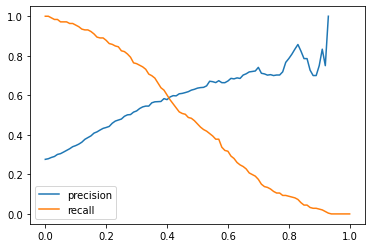

In [70]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

In [77]:
# Ans : 0.3

In [72]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    f1 = 2 * p * r / (p + r)
    
    scores.append((t, tp, fp, fn, tn, p, r, f1))

c:\python\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars


In [73]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall', 'f1']
df_scores = pd.DataFrame(scores, columns=columns)

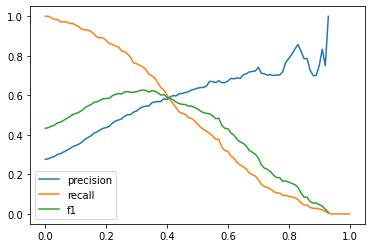

In [74]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.plot(df_scores.threshold, df_scores['f1'], label='f1')
plt.legend()

In [76]:
df_scores[::10]

,threshold,tp,fp,fn,tn,precision,recall,f1
0,0.0,246,645,0,0,0.276094,1.000000,0.432718
10,0.1,235,445,11,200,0.345588,0.955285,0.507559
20,0.2,216,278,30,367,0.437247,0.878049,0.583784
30,0.3,187,172,59,473,0.520891,0.760163,0.618182
40,0.4,148,108,98,537,0.578125,0.601626,0.589641
50,0.5,112,64,134,581,0.636364,0.455285,0.530806
60,0.6,78,38,168,607,0.672414,0.317073,0.430939
70,0.7,43,15,203,630,0.741379,0.174797,0.282895
80,0.8,22,6,224,639,0.785714,0.089431,0.160584
90,0.9,6,2,240,643,0.750000,0.024390,0.047244


## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the AUC scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

In [90]:
# Ans : 0.014

In [91]:
from sklearn.model_selection import KFold

In [87]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx][features]
    df_val = df_full_train.iloc[val_idx][features]

    y_train = df_full_train.iloc[train_idx].default.values
    y_val = df_full_train.iloc[val_idx].default.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [88]:
scores

[0.8256311256311257,
 0.8254077031563475,
 0.7878437624551613,
 0.8250108084738436,
 0.8054885489684138]

In [89]:
np.std(scores)

0.015120673541066436

## Question 6
Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [96]:
# Ans 0.01

In [94]:
n_splits = 5

for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx][features]
        df_val = df_full_train.iloc[val_idx][features]

        y_train = df_full_train.iloc[train_idx].default.values
        y_val = df_full_train.iloc[val_idx].default.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.814 +- 0.015
C=0.1 0.814 +- 0.015
C=1 0.814 +- 0.015
C=10 0.814 +- 0.015


In [95]:
scores

[0.8256311256311257,
 0.8254077031563475,
 0.7878437624551613,
 0.8250108084738436,
 0.8054885489684138]

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.



## Nagivation

* [Machine Learning Zoomcamp course](../)
* [Session 4: Evaluation Metrics for Classification](./)
* Previous: [Explore more](09-explore-more.md)